# Scraping StackOverflow
This notebook scrapes StackOverflow for dask-tagged questions and puts the cleaned data into a DataFrame for further analysis.

## Scraping Data

In [1]:
import re
import time

import pandas as pd
import requests
from requests_html import HTML

In [2]:
base_url = "https://stackoverflow.com/questions/tagged/"
tag = "dask"
query_filter = "Newest"
url = f"{base_url}{tag}?tab={query_filter}"
url

'https://stackoverflow.com/questions/tagged/dask?tab=Newest'

In [3]:
r = requests.get(url)
html_str = r.text
html = HTML(html=html_str)

In [4]:
question_elements = html.find(".s-post-summary")

In [5]:
print(question_elements[0].text)

0 votes
0 answers
4 views
can I use columns with object type in xgboost?
I want to develop Xgboost model on Dask. I import parquet files and all columns have object type. Do I need to convert column's type from object to numeric? If do, what is most convenient way to do ...
machine-learning
dask
xgboost
dask-distributed
dask-dataframe
Lev1990
7
asked 8 mins ago


### Get Data for 1 Question

In [6]:
# get most recent question element
this_question_element = question_elements[0]

In [7]:
# inspect element
this_question_element.text

'0 votes\n0 answers\n23 views\nDask and persistence of data on the cluster\nI am working on a project that uses historical data and also incoming data for analysis. I would like to learn how to manage updating incoming data on dask while not having to dispatch all the ...\npython\ndask\nmatt\n33\nasked yesterday'

In [8]:
# get question title
this_question_element.find(".s-link", first=True).text

'Dask and persistence of data on the cluster'

In [9]:
# get stats (formatted more nicely)
this_question_element.find(".s-post-summary--stats", first=True).text.replace("\n", " ")

'0 votes 0 answers 23 views'

In [10]:
# get metadata
this_question_element.find(".s-post-summary--meta", first=True).text.replace("\n", " ")

'python dask matt 33 asked yesterday'

In [11]:
# get question excerpt
this_question_element.find(".s-post-summary--content-excerpt", first=True).text

'I am working on a project that uses historical data and also incoming data for analysis. I would like to learn how to manage updating incoming data on dask while not having to dispatch all the ...'

In [12]:
# get question title
this_question_element.find(".s-post-summary--content-title", first=True).text

'Dask and persistence of data on the cluster'

In [13]:
# get question hyperlink
this_question_element.find(".s-link", first=True)

<Element 'a' href='/questions/74367670/dask-and-persistence-of-data-on-the-cluster' class=('s-link',)>

### Get Data for All Questions


We want to ideally get:
- the question title
- answered / unanswered status ( get from n_answers )
- number of answers
- number of votes
- number of views
- tags (this one might be tricky)
- the question hyperlink (unsure yet how to do exactly)
- timestamp would be nice
- 

In [6]:
# define keynames and quetions needed
keynames = ["title", "stats", "tags"]
classes_needed = [
    ".s-post-summary--content-title",
    ".s-post-summary--stats",
    ".s-post-summary--meta-tags",
]

In [7]:
datas = []

for q_el in question_elements:
    q_data = {}
    for i, _class in enumerate(classes_needed):
        sub_el = q_el.find(_class, first=True)
        keyname = keynames[i]
        q_data[keyname] = sub_el.text
    datas.append(q_data)

In [8]:
df = pd.DataFrame(datas)
df.head(3)

,title,stats,tags
0,can I use columns with object type in xgboost?,0 votes\n0 answers\n4 views,machine-learning\ndask\nxgboost\ndask-distribu...
1,How to read a text file using dask where the r...,-1 votes\n0 answers\n14 views,python\ndask
2,Dask - Is there a way to get disconnected/netw...,0 votes\n0 answers\n7 views,dask\ndask-distributed


OK, the basics are working here.

Let's now refine:
- Separate votes, answers, and views into separate columns
- Separate tags into separate colum

In [9]:
# get stats and split
this_question_element.find(".s-post-summary--stats", first=True).text.split("\n")

NameError: name 'this_question_element' is not defined

In [18]:
# get only numbers
stats_test = re.findall(
    r"\d+", this_question_element.find(".s-post-summary--stats", first=True).text
)
stats_test

['0', '0', '23']

In [19]:
# get just tags
this_question_element.find(".s-post-summary--meta-tags", first=True).text.split("\n")

['python', 'dask']

OK, we now have clean tags and stats. Let's try this again:

In [9]:
# function that will clean the scraped data
def clean_scraped_data(text, keyname=None):
    if keyname == "stats":
        rep = {
            " vote": "",
            " answer": "",
            " view": "",
            "s": "",
        }  # remove singular instances first, then remove all remaining "s"
        # replace
        rep = dict((re.escape(k), v) for k, v in rep.items())
        pattern = re.compile("|".join(rep.keys()))
        text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
        text = text.split("\n")
        # replace any k with 000
        new_text = []
        for n in text:
            res = re.sub("k", "000", n)
            n = int(res)
            new_text.append(n)
        return new_text

    elif keyname == "tags":
        return text.split("\n")
    return text

In [10]:
datas = []

for q_el in question_elements:
    q_data = {}
    for i, _class in enumerate(classes_needed):
        sub_el = q_el.find(_class, first=True)
        keyname = keynames[i]
        q_data[keyname] = clean_scraped_data(sub_el.text, keyname=keyname)
    datas.append(q_data)

In [11]:
df = pd.DataFrame(datas)
df.head()

,title,stats,tags
0,can I use columns with object type in xgboost?,"[0, 0, 4]","[machine-learning, dask, xgboost, dask-distrib..."
1,How to read a text file using dask where the r...,"[-1, 0, 14]","[python, dask]"
2,Dask - Is there a way to get disconnected/netw...,"[0, 0, 7]","[dask, dask-distributed]"
3,Csv file search speedup,"[0, 2, 31]","[pandas, dask, dask-dataframe]"
4,Looking up value in csv file,"[0, 1, 42]","[python, pandas, csv, filter, dask]"


Sweet. This is working for the first 50 results.

In [12]:
# define function that will parse a single page
def parse_tagged_page(html):
    question_elements = html.find(".s-post-summary")
    keynames = ["title", "stats", "tags"]
    classes_needed = [
        ".s-post-summary--content-title",
        ".s-post-summary--stats",
        ".s-post-summary--meta-tags",
    ]
    datas = []
    for q_el in question_elements:
        q_data = {}
        for i, _class in enumerate(classes_needed):
            sub_el = q_el.find(_class, first=True)
            keyname = keynames[i]
            q_data[keyname] = clean_scraped_data(sub_el.text, keyname=keyname)
        datas.append(q_data)
    return datas

In [13]:
# define function that will extract data from url
def extract_data_from_url(url):
    r = requests.get(url)
    if r.status_code not in range(200, 299):
        return []
    html_str = r.text
    html = HTML(html=html_str)
    datas = parse_tagged_page(html)
    return datas

In [14]:
# function that will scrape the entire tag
def scrape_tag(tag="python", query_filter="Newest", max_pages=100, pagesize=50):
    base_url = "https://stackoverflow.com/questions/tagged/"
    datas = []
    for p in range(max_pages):
        page_num = p + 1
        url = f"{base_url}{tag}?tab={query_filter}&page={page_num}&pagesize={pagesize}"
        datas += extract_data_from_url(url)
        time.sleep(1.2)
    return datas

In [29]:
%%time
seq = scrape_tag(max_pages=10)

CPU times: user 3.52 s, sys: 388 ms, total: 3.91 s
Wall time: 19.8 s


In [34]:
# function that will scrape the entire tag
def scrape_tag_single(max_pages, tag="python", query_filter="Newest", pagesize=50):
    base_url = "https://stackoverflow.com/questions/tagged/"
    datas = []
    p = max_pages
    url = f"{base_url}{tag}?tab={query_filter}&page={p}&pagesize={pagesize}"
    datas += extract_data_from_url(url)
    time.sleep(1.2)
    return datas

In [19]:
from distributed import Client
client = Client()

/Users/rpelgrim/mambaforge/envs/scrape/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57013 instead
  warnings.warn(


## Client.map

In [23]:
from distributed import wait

In [36]:
%%time
t = client.map(scrape_tag_single, range(10))
wait(t)

CPU times: user 16.8 ms, sys: 3.69 ms, total: 20.5 ms
Wall time: 19.7 ms


DoneAndNotDoneFutures(done={<Future: finished, type: list, key: scrape_tag_single-17bf1b0dcc8e38ea17519282a6de5a83>, <Future: finished, type: list, key: scrape_tag_single-24cc2f8b2c456b0f993cc8ca2176ff30>, <Future: finished, type: list, key: scrape_tag_single-bb084bb71b96e202eb3e9c72c6dfbe82>, <Future: finished, type: list, key: scrape_tag_single-7d6433dca6406e68b0f780575a3c83eb>, <Future: finished, type: list, key: scrape_tag_single-714c201077b05f5ecaa2ee98db2e6d96>, <Future: finished, type: list, key: scrape_tag_single-47026530175aed9c79d6d115290448dc>, <Future: finished, type: list, key: scrape_tag_single-198b636944619c22d20a20525049a8f5>, <Future: finished, type: list, key: scrape_tag_single-863979211b89758085df3a77b7e9f8dc>, <Future: finished, type: list, key: scrape_tag_single-3cc0ea89604534d55d2d60d2ce30411f>, <Future: finished, type: list, key: scrape_tag_single-b7017e4df5c0f18709c7ea4ab8f689b6>}, not_done=set())

In [ ]:
client.gather(t)

## Client.submit

In [33]:
%%time

# function that will scrape the entire tag
base_url = "https://stackoverflow.com/questions/tagged/"
tag = "python"
max_pages = 10
pagesize = 50
query_filter = "Newest"
datas = []

for p in range(max_pages):
    page_num = p + 1
    url = f"{base_url}{tag}?tab={query_filter}&page={page_num}&pagesize={pagesize}"
    datas.append(client.submit(extract_data_from_url, url))
    time.sleep(1.2)


wait(datas)

CPU times: user 914 ms, sys: 241 ms, total: 1.16 s
Wall time: 12 s


DoneAndNotDoneFutures(done={<Future: finished, type: list, key: extract_data_from_url-d7e0116e941d2e23cfc1a92882994763>, <Future: finished, type: list, key: extract_data_from_url-8c61af35e86d4feb931c3eb4cd7d2ae6>, <Future: finished, type: list, key: extract_data_from_url-58a7da78e8a18b276f554d84a771479f>, <Future: finished, type: list, key: extract_data_from_url-08774f42e61962d120d885121ee8c62f>, <Future: finished, type: list, key: extract_data_from_url-c4f561b32fa10d57ec05200a41274bf5>, <Future: finished, type: list, key: extract_data_from_url-ae95250fb98f257376ac7355035a642c>, <Future: finished, type: list, key: extract_data_from_url-10b5a5d8a48d527e3d6a9ef73bb8e850>, <Future: finished, type: list, key: extract_data_from_url-61e672fa1e377f950ea2706a52e3210a>, <Future: finished, type: list, key: extract_data_from_url-e1137986f80e096e1ccfcdb1d6039a41>, <Future: finished, type: list, key: extract_data_from_url-bde5fe93ccb9ef1e9329987caf468c79>}, not_done=set())

In [37]:
# iterate over urls instead
urls = [f"{base_url}{tag}?tab={query_filter}&page={page_num}&pagesize={pagesize}" for page_num in max_pages]
urls

# imitate this example
results = []
for i in range(20):
    results.append(client.submit(add_things, 1, 2, i))

TypeError: 'int' object is not iterable

In [32]:
%%time
datas = scrape_tag_submit(max_pages=10)
wait(datas)

CPU times: user 793 ms, sys: 190 ms, total: 983 ms
Wall time: 12.1 s


DoneAndNotDoneFutures(done={<Future: finished, type: list, key: extract_data_from_url-d7e0116e941d2e23cfc1a92882994763>, <Future: finished, type: list, key: extract_data_from_url-08774f42e61962d120d885121ee8c62f>, <Future: finished, type: list, key: extract_data_from_url-ae95250fb98f257376ac7355035a642c>, <Future: finished, type: list, key: extract_data_from_url-c4f561b32fa10d57ec05200a41274bf5>, <Future: finished, type: list, key: extract_data_from_url-10b5a5d8a48d527e3d6a9ef73bb8e850>, <Future: finished, type: list, key: extract_data_from_url-58a7da78e8a18b276f554d84a771479f>, <Future: finished, type: list, key: extract_data_from_url-8c61af35e86d4feb931c3eb4cd7d2ae6>, <Future: finished, type: list, key: extract_data_from_url-bde5fe93ccb9ef1e9329987caf468c79>, <Future: finished, type: list, key: extract_data_from_url-e1137986f80e096e1ccfcdb1d6039a41>, <Future: finished, type: list, key: extract_data_from_url-61e672fa1e377f950ea2706a52e3210a>}, not_done=set())

This is not great yet, let's improve.

In [16]:
%%time
datas = scrape_tag(tag="dask")

CPU times: user 22.2 s, sys: 615 ms, total: 22.8 s
Wall time: 3min 13s


In [73]:
df = pd.DataFrame(datas)
df.head()

,title,stats,tags
0,Dask and persistence of data on the cluster,"[0, 0, 23]","[python, dask]"
1,calculating many dask delayed objects together; message as soon as each...,"[0, 1, 20]","[python, dask]"
2,Find out which rows of one 2D numpy array are represented in another 2D...,"[-1, 3, 30]","[python, arrays, numpy, vectorization, dask]"
3,dask-ml preprocessing raise AttributeError,"[0, 0, 16]","[python, dask, dask-dataframe, dask-ml]"
4,How to setup dask clusters and client by submitting a job on an HPC sys...,"[1, 0, 11]","[python, dask, dask-distributed]"


In [74]:
len(df)

4145

## Clean up dataframe

In [75]:
# get stats into separate columns
df[["votes", "answers", "views"]] = pd.DataFrame(df["stats"].to_list())
df = df.drop(columns=["stats"])
df.head()

,title,tags,votes,answers,views
0,Dask and persistence of data on the cluster,"[python, dask]",0,0,23
1,calculating many dask delayed objects together; message as soon as each...,"[python, dask]",0,1,20
2,Find out which rows of one 2D numpy array are represented in another 2D...,"[python, arrays, numpy, vectorization, dask]",-1,3,30
3,dask-ml preprocessing raise AttributeError,"[python, dask, dask-dataframe, dask-ml]",0,0,16
4,How to setup dask clusters and client by submitting a job on an HPC sys...,"[python, dask, dask-distributed]",1,0,11


In [76]:
# TO DO
# 1. Fetch question URL
# 2. Fetch question timestamp
# 3. Create "answered" true/false column
# 4. For fun: use Futures to fetch data in parallel

## Run some analyses

In [80]:
# increase max col_width to see more of the titles
pd.options.display.max_colwidth = 100

In [81]:
# most-upvoted questions
df.sort_values("votes", ascending=False).head(10)

,title,tags,votes,answers,views
3677,Make Pandas DataFrame apply() use all cores?,"[pandas, dask]",170,12,126000
4047,At what situation I can use Dask instead of Apache Spark? [closed],"[python, pandas, apache-spark, dask]",101,1,41000
3155,A comparison between fastparquet and pyarrow?,"[python, parquet, dask, pyarrow, fastparquet]",66,5,43000
4039,How to transform Dask.DataFrame to pd.DataFrame?,"[python, pandas, dask]",53,3,37000
4143,"python dask DataFrame, support for (trivially parallelizable) row apply?","[python, pandas, parallel-processing, dask]",51,2,25000
3991,Convert Pandas dataframe to Dask dataframe,"[python, pandas, dataframe, data-conversion, dask]",47,1,51000
3711,Out-of-core processing of sparse CSR arrays,"[python, scipy, apache-spark-mllib, dask, joblib]",43,1,2000
3997,Writing Dask partitions into single file,"[python, dask]",34,2,16000
4001,Writing Dask partitions into single file,"[python, dask]",34,2,16000
3970,Can dask parralelize reading fom a csv file?,"[python, csv, pandas, dask]",32,2,26000


In [84]:
# most-viewed questions
df.sort_values("views", ascending=False).head(10)

,title,tags,votes,answers,views
3677,Make Pandas DataFrame apply() use all cores?,"[pandas, dask]",170,12,126000
3991,Convert Pandas dataframe to Dask dataframe,"[python, pandas, dataframe, data-conversion, dask]",47,1,51000
3155,A comparison between fastparquet and pyarrow?,"[python, parquet, dask, pyarrow, fastparquet]",66,5,43000
4047,At what situation I can use Dask instead of Apache Spark? [closed],"[python, pandas, apache-spark, dask]",101,1,41000
4039,How to transform Dask.DataFrame to pd.DataFrame?,"[python, pandas, dask]",53,3,37000
4028,"Convert string to dict, then access key:values??? How to access data in a <class 'dict'> for Pyt...","[python, pandas, dictionary, data-manipulation, dask]",19,4,34000
3908,"Default pip installation of Dask gives ""ImportError: No module named toolz""","[python, installation, pip, importerror, dask]",22,6,28000
3996,dask dataframe how to convert column to to_datetime,"[python, pandas, dask]",19,5,28000
2125,Only a column name can be used for the key in a dtype mappings argument,"[python, pandas, dask]",9,1,28000
4000,dask dataframe how to convert column to to_datetime,"[python, pandas, dask]",19,5,28000


These popular questions could be used to drive content-creation on the Dask blog / social channels.

In [61]:
# most common tags

# get all tags into a list of lists
all_tags = []
for row in df.tags:
    all_tags.append(row)

from collections import Counter
from itertools import chain

# count all tags
c = Counter(chain(*all_tags))

# transform into dataframe
df = pd.DataFrame.from_dict(c, orient="index").reset_index()
df.sort_values(0, ascending=False).head(10)

,index,0
1,dask,4145
0,python,2672
9,pandas,1091
7,dask-distributed,954
8,dataframe,468
5,dask-dataframe,311
23,python-3.x,274
17,dask-delayed,256
3,numpy,175
15,python-xarray,175


In [62]:
# drop "dask" and "python" tags
df = df[df["index"] != "dask"]
df = df[df["index"] != "python"]
df = df[df["index"] != "python-3.x"]

In [63]:
df.sort_values(0, ascending=False).head(10)

,index,0
9,pandas,1091
7,dask-distributed,954
8,dataframe,468
5,dask-dataframe,311
17,dask-delayed,256
3,numpy,175
15,python-xarray,175
43,parallel-processing,161
16,parquet,135
48,csv,113


In [64]:
df = df.rename(columns={"index": "tag", 0: "count"})
df.sort_values("count", ascending=False).head(10)

,tag,count
9,pandas,1091
7,dask-distributed,954
8,dataframe,468
5,dask-dataframe,311
17,dask-delayed,256
3,numpy,175
15,python-xarray,175
43,parallel-processing,161
16,parquet,135
48,csv,113


In [65]:
import matplotlib.pyplot as plt

In [68]:
df_plot = df.sort_values("count", ascending=False).head(10).reset_index(drop=True)

<AxesSubplot: ylabel='count'>

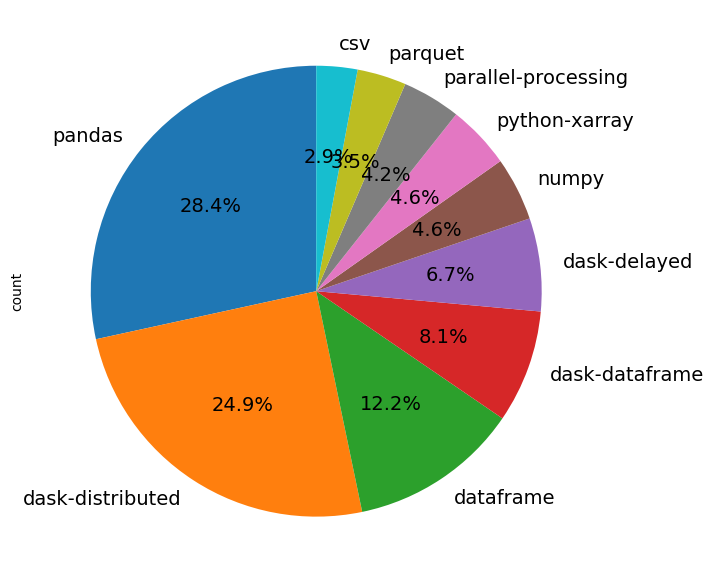

In [69]:
plt.figure(figsize=(16, 8))
# plot chart
ax1 = plt.subplot(121, aspect="equal")
df_plot.plot(
    kind="pie",
    y="count",
    ax=ax1,
    autopct="%1.1f%%",
    startangle=90,
    shadow=False,
    labels=df_plot.tag,
    legend=False,
    fontsize=14,
)

These give some indication of the Collections folks are using / running into issues with.

Assuming that all "pandas"-tagged questions are DataFrame questions, that would mean that **almost half of the questions (48.7%) are related to Dask DataFrame**.

## Possible Next Steps

It would be interesting to:
- Run topic modelling on Dask DataFrame questions to get more fine-grained understanding of what folks are running into
- Same for dask-distributed
- Add timestamps to questions to see how questions/usage seems to change over time
- Build out analyses for other platforms and compare.
- ...

## Keep in Mind

Ian shared this, try it out: https://data.stackexchange.com/stackoverflow/query/edit/1491554